# Overview

This notebook is used for the development of the auto slit conrner detection algorithm, which is critical for the automated detector drift correction.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.signal import medfilt2d
from scipy.signal import find_peaks
from skimage import exposure
from skimage.transform import match_histograms

from scipy.ndimage import gaussian_filter1d
from tomoproc.util.npmath import discrete_cdf

from scipy.optimize import curve_fit

In [2]:
val_atPercent = lambda ar, p: np.sort(ar.flatten())[int(np.prod(ar.shape)*p)] 
wgt_histequal = lambda ar: (np.sort(ar.flatten()).searchsorted(ar) + 1)/np.prod(ar.shape)
wgts_binned   = lambda wgts, bins: np.int64(np.floor(wgts * bins)).astype(wgts.dtype) / bins

# Initial test with the first image

let's import one images and start with the code we submitted to tomopy a long time ago.

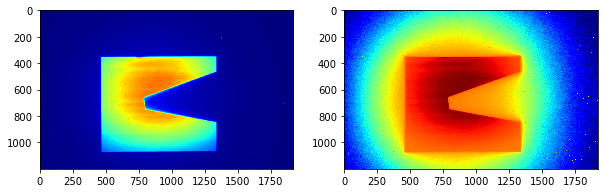

In [3]:
rawimg = plt.imread('data/test_midregion_1.tif')

fig, axes = plt.subplots(1,2,figsize=(10, 5))

img = exposure.equalize_hist(rawimg)

axes[0].imshow(rawimg, 'jet')
axes[1].imshow(img, 'jet')

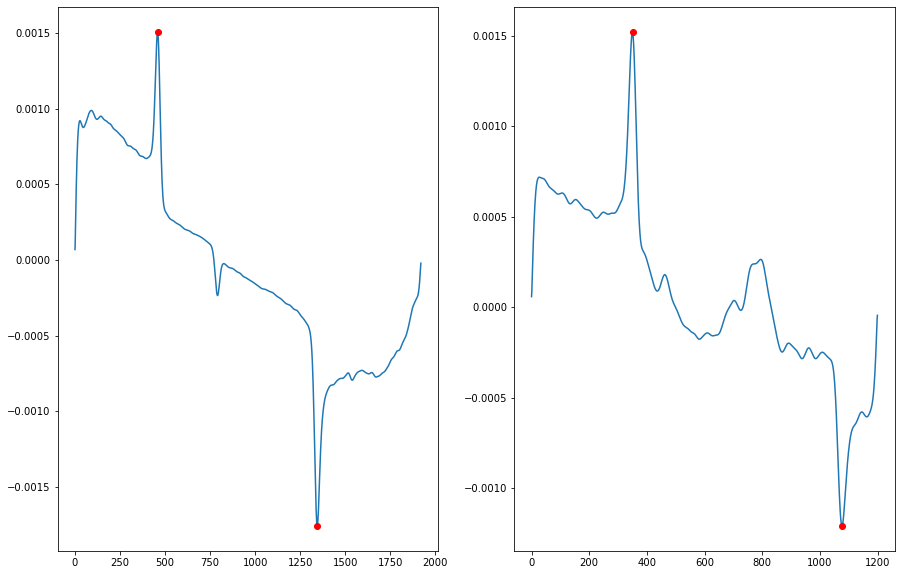

In [4]:
tmp = np.log(medfilt2d(img.astype(float))+1)

col_prof = gaussian_filter1d(np.average(tmp, axis=0), sigma=11)
dot_col_prof = np.gradient(col_prof)

left = np.argmax(dot_col_prof)
right = np.argmin(dot_col_prof)

row_prof = gaussian_filter1d(np.average(tmp, axis=1), sigma=11)
dot_row_prof = np.gradient(row_prof)

top = np.argmax(dot_row_prof)
bot = np.argmin(dot_row_prof)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].plot(dot_col_prof)
axes[0].plot(left, dot_col_prof[left], 'ro')
axes[0].plot(right, dot_col_prof[right], 'ro')

axes[1].plot(dot_row_prof)
axes[1].plot(top, dot_row_prof[top], 'ro')
axes[1].plot(bot, dot_row_prof[bot], 'ro')


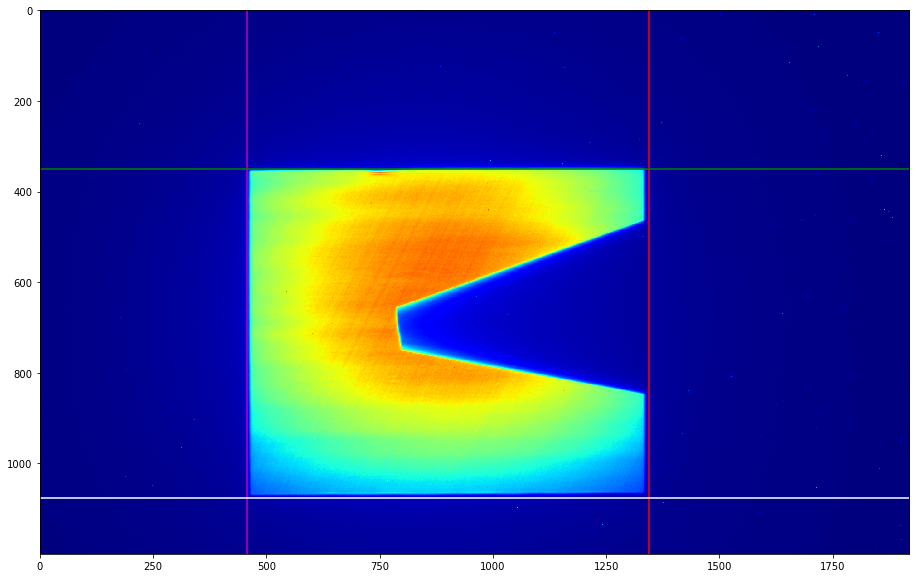

In [5]:
fig, ax = plt.subplots(1,1,figsize=(18, 10))

ax.imshow(rawimg, 'jet')

ax.axvline(left, color='m')
ax.axvline(right, color='r')

ax.axhline(top, color='g')
ax.axhline(bot, color='w')

Making it into a function

{'left': 461, 'right': 1335, 'top': 350, 'bot': 1069}


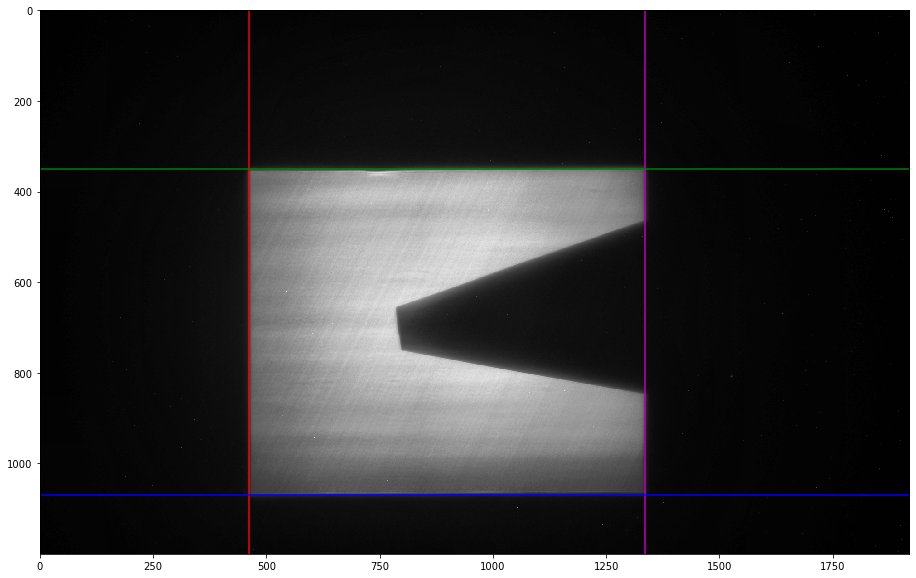

In [20]:
def guess_slit_box(img):
    
    # Contrast stretching
    pl, ph = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(pl, ph))
    
    # equilize hist
    img = exposure.equalize_adapthist(img)
    
    # map to log to reveal transition box
    img = np.log(medfilt2d(img.astype(float))+1)
    
    # get row and col profile gradient
    pdot_col = np.gradient(gaussian_filter1d(np.average(img, axis=0), sigma=11))
    pdot_row = np.gradient(gaussian_filter1d(np.average(img, axis=1), sigma=11))

    return {
        'left':  np.argmax(pdot_col),
        'right': np.argmin(pdot_col),
        'top':   np.argmax(pdot_row),
        'bot':   np.argmin(pdot_row),
    }


# --------------
# testing
rawimg = plt.imread('data/test_midregion_1.tif')

edges = guess_slit_box(rawimg)

fig, ax = plt.subplots(1,1,figsize=(18, 10))

# ax.imshow(rawimg, 'gray')
# ax.imshow(exposure.equalize_hist(rawimg), 'gray')
ax.imshow(exposure.equalize_adapthist(rawimg), 'gray')

ax.axvline(edges['left'],  color='r')
ax.axvline(edges['right'], color='m')
ax.axhline(edges['top'],   color='g')
ax.axhline(edges['bot'],   color='b')

print(edges)

In [21]:
%timeit edges = guess_slit_box(rawimg)

395 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Systematic test under different conditions

## Standard case

In most cases, the majority of detector should be used for imaging.

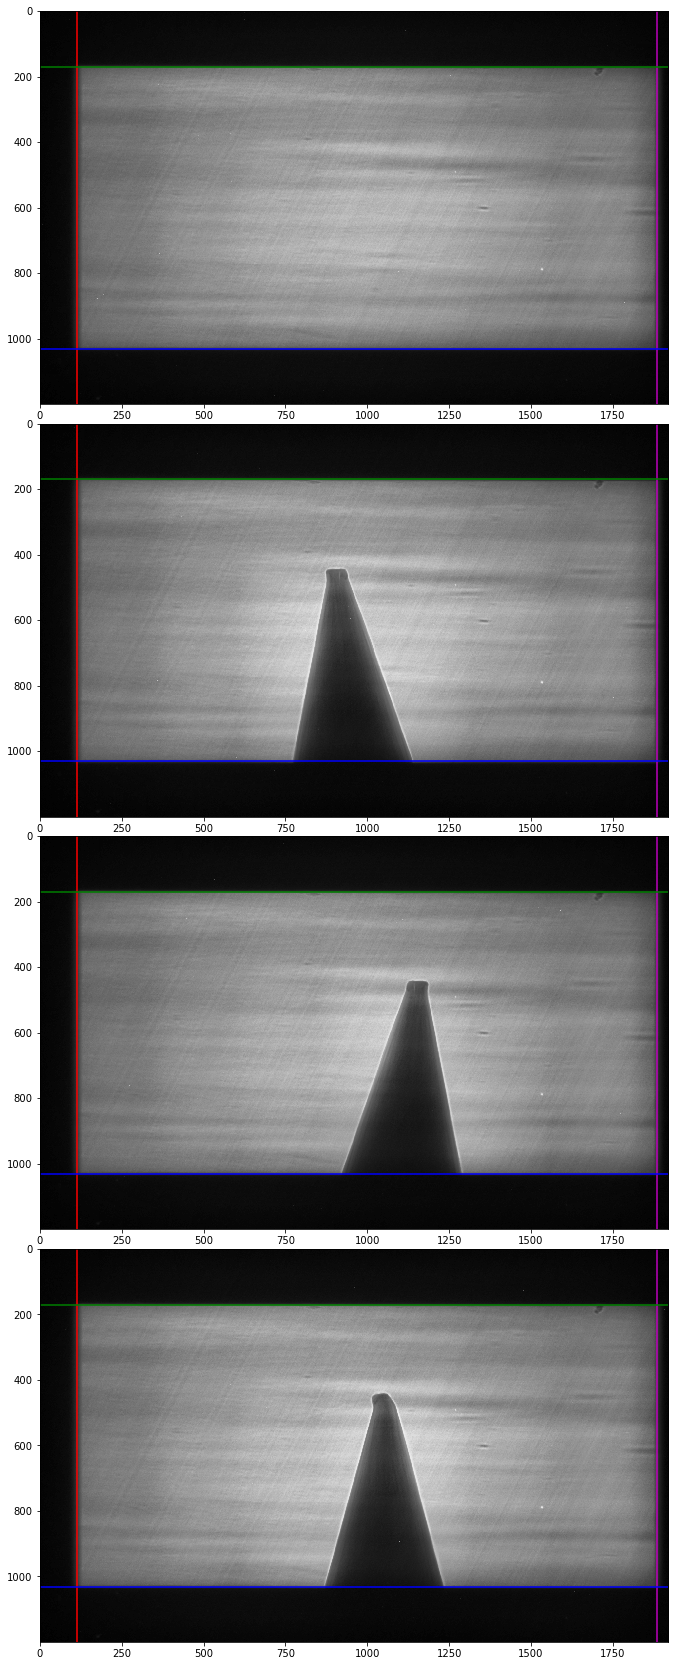

In [16]:
# we have 0-3, 4 regular cases here

fig, axs = plt.subplots(4, 1, figsize=(15, 30))

for i in range(4):
    img = plt.imread(f'data/test_bigregion_{i}.tif')
    edges = guess_slit_box(img)
    axs[i].imshow(exposure.equalize_adapthist(img), 'gray')
    axs[i].axvline(edges['left'],  color='r')
    axs[i].axvline(edges['right'], color='m')
    axs[i].axhline(edges['top'],   color='g')
    axs[i].axhline(edges['bot'],   color='b')

plt.subplots_adjust(wspace=0, hspace=0.05)

## Mid region case

In some cases, a good region of the detector is purposely selected for imaging.

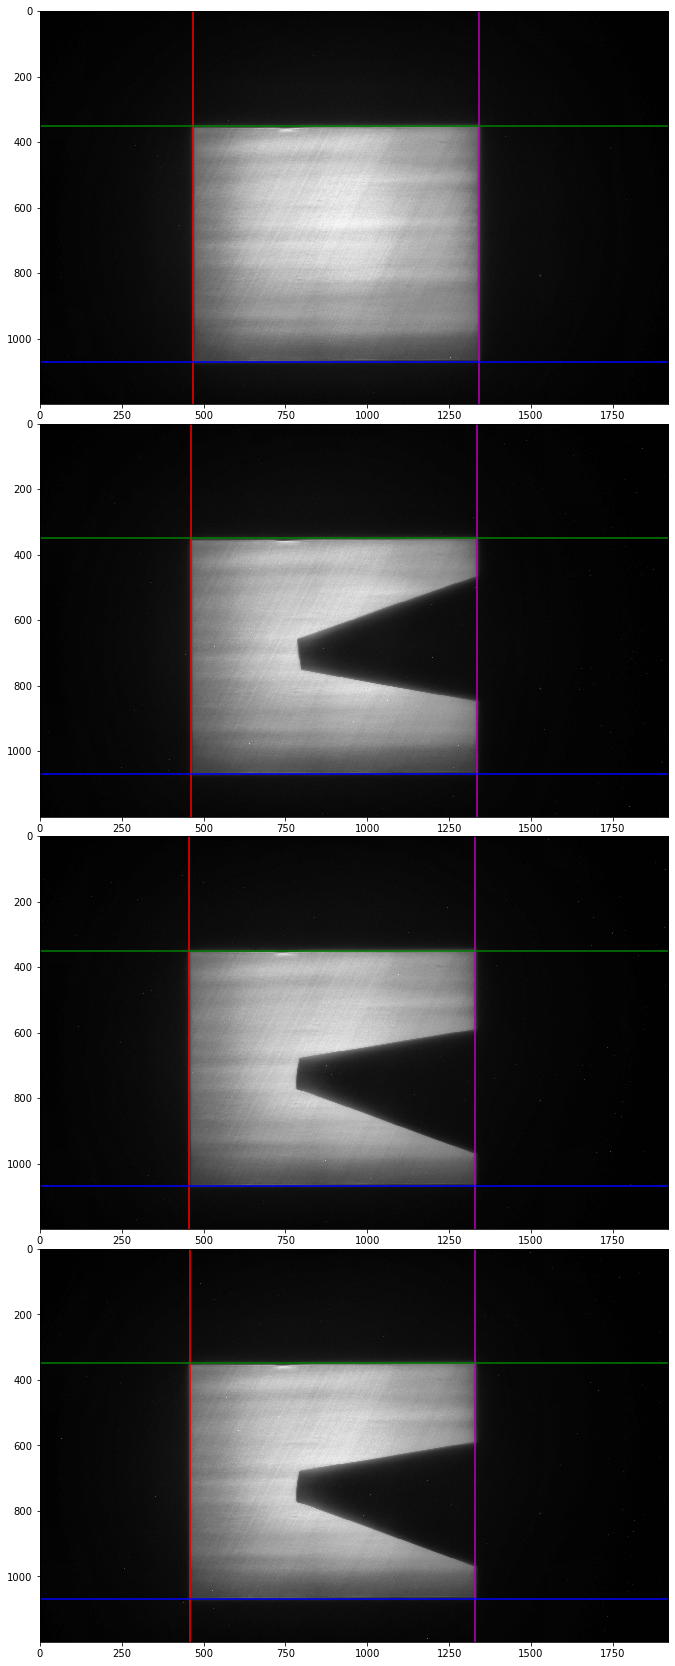

In [17]:
# we have 0-3, 4 mid region cases here

fig, axs = plt.subplots(4, 1, figsize=(15, 30))

for i in range(4):
    img = plt.imread(f'data/test_midregion_{i}.tif')
    edges = guess_slit_box(img)
    axs[i].imshow(exposure.equalize_adapthist(img), 'gray')
    axs[i].axvline(edges['left'],  color='r')
    axs[i].axvline(edges['right'], color='m')
    axs[i].axhline(edges['top'],   color='g')
    axs[i].axhline(edges['bot'],   color='b')

plt.subplots_adjust(wspace=0, hspace=0.05)

## Small region cases

In very rare situation, the imaging region is shrinked to a really small region on the detector.

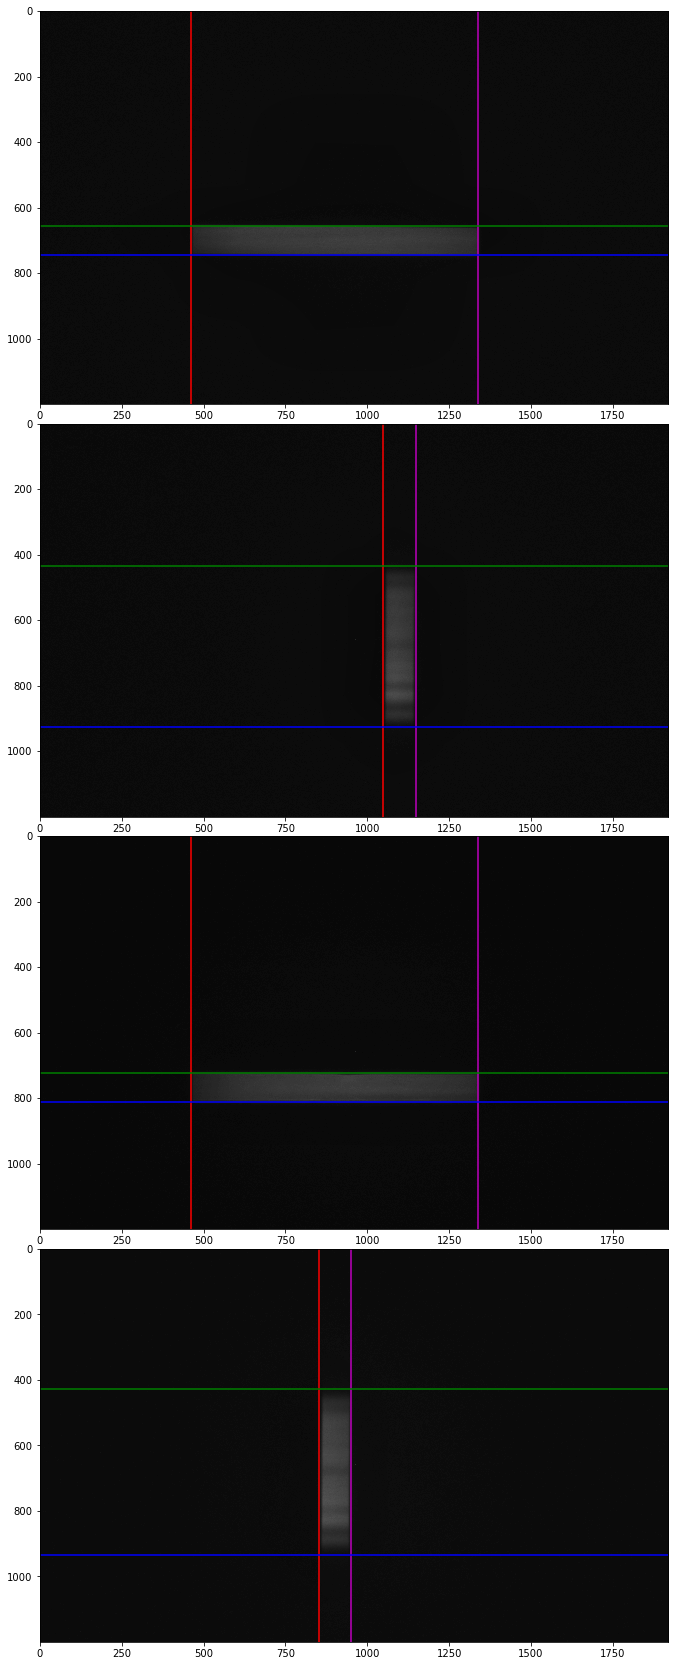

In [18]:
# we have 0-3, 4 small region cases here

fig, axs = plt.subplots(4, 1, figsize=(15, 30))

for i in range(4):
    img = plt.imread(f'data/test_smallregion_{i}.tif')
    edges = guess_slit_box(img)
    axs[i].imshow(exposure.equalize_adapthist(img), 'gray')
    axs[i].axvline(edges['left'],  color='r')
    axs[i].axvline(edges['right'], color='m')
    axs[i].axhline(edges['top'],   color='g')
    axs[i].axhline(edges['bot'],   color='b')

plt.subplots_adjust(wspace=0, hspace=0.05)

Basically, as long as all four blade slits are used, the function should be able to return the approximated location of the four blades without any trouble.  However, if there is no slits at all, random results will be returned.

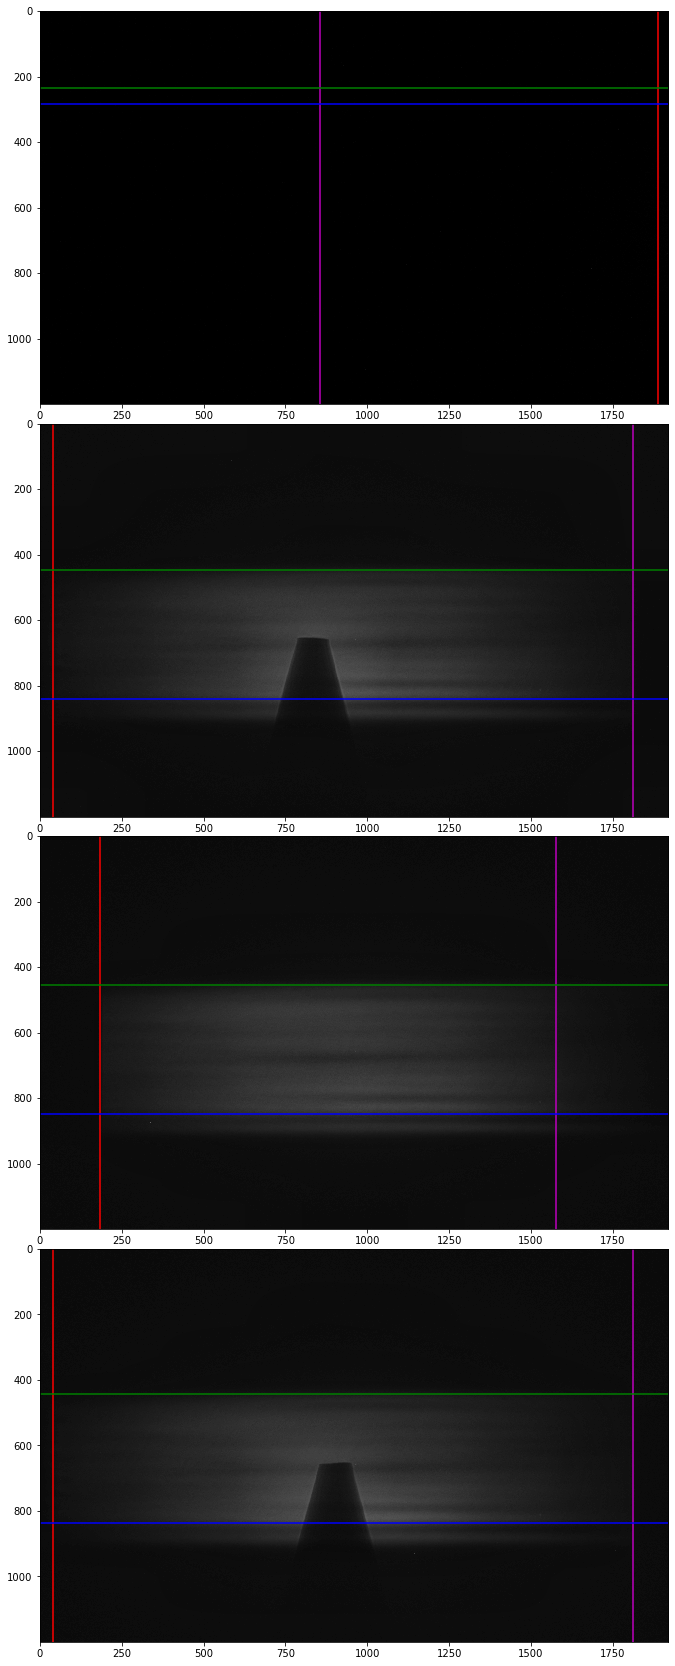

In [19]:
# we have 0-3, 4 no slit cases here

fig, axs = plt.subplots(4, 1, figsize=(15, 30))

for i in range(4):
    img = plt.imread(f'data/test_noslit_{i}.tif')
    edges = guess_slit_box(img)
    axs[i].imshow(exposure.equalize_adapthist(img), 'gray')
    axs[i].axvline(edges['left'],  color='r')
    axs[i].axvline(edges['right'], color='m')
    axs[i].axhline(edges['top'],   color='g')
    axs[i].axhline(edges['bot'],   color='b')

plt.subplots_adjust(wspace=0, hspace=0.05)

The key point here is that we should only use this slit box finder if we know that slits are used in the experiment, not the other way around.

# Detect slit corner

Use peak fitting method to get more accurate position of the four slit corner

{'left': 114, 'right': 1884, 'top': 170, 'bot': 1031}


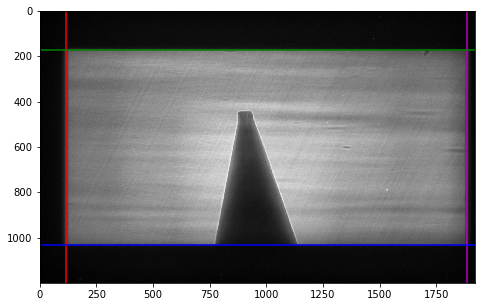

In [86]:
# test case
rawimg = plt.imread('data/test_bigregion_1.tif')

edges = guess_slit_box(rawimg)

fig, ax = plt.subplots(1,1,figsize=(10, 5))

# ax.imshow(rawimg, 'gray')
# ax.imshow(exposure.equalize_hist(rawimg), 'gray')
ax.imshow(exposure.equalize_adapthist(rawimg), 'gray')

ax.axvline(edges['left'],  color='r')
ax.axvline(edges['right'], color='m')
ax.axhline(edges['top'],   color='g')
ax.axhline(edges['bot'],   color='b')

print(edges)

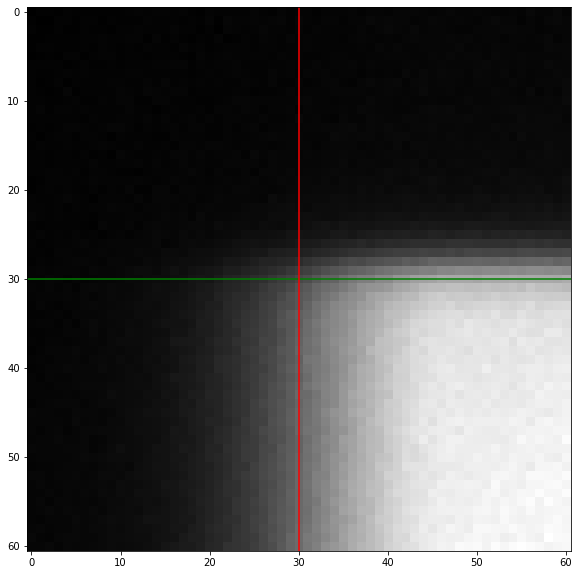

In [89]:
# img = exposure.equalize_adapthist(rawimg)
img = rawimg

r = 30
top_left_corner = img[edges['top' ]-r:edges['top' ]+r+1,
                      edges['left']-r:edges['left']+r+1]

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(top_left_corner, 'gray')

ax.axhline(r, color='g')
ax.axvline(r, color='r')

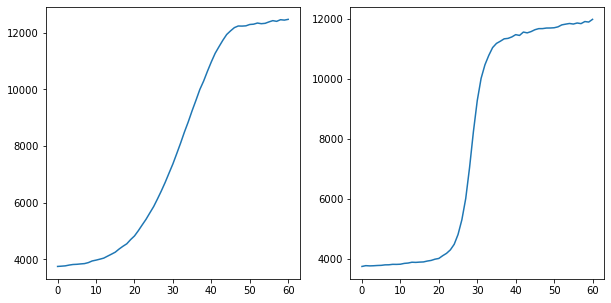

In [90]:
horizontal_lp = np.average(top_left_corner, axis=0)
vertical_lp = np.average(top_left_corner, axis=1)

fig, ax = plt.subplots(1,2,figsize=(10, 5))

ax[0].plot(horizontal_lp)
ax[1].plot(vertical_lp)

seems like we should use logistic function here

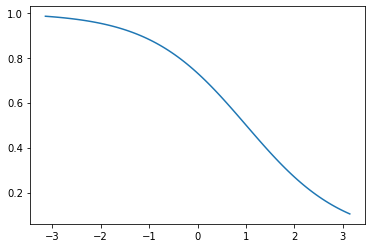

In [102]:
def sigmoid(x, xc=0, a=1):
    return 1.0/(1.0 + np.exp(-a*(x - xc)))

xx = np.linspace(-np.pi, np.pi, 100)
yy = sigmoid(xx, xc=1, a=-1)

plt.plot(xx, yy)

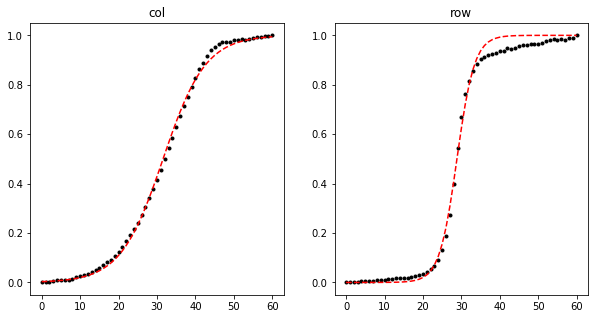

In [110]:
# testing case 

rawimg = plt.imread('data/test_bigregion_1.tif')
edges = guess_slit_box(rawimg)

r = 30
top_left_corner = img[edges['top' ]-r:edges['top' ]+r+1,
                      edges['left']-r:edges['left']+r+1]

horizontal_lp = np.average(top_left_corner, axis=0)
vertical_lp = np.average(top_left_corner, axis=1)


# fit the logistic curve
fig, ax = plt.subplots(1,2,figsize=(10,5))

# first horizontal position, col pos
tmp = horizontal_lp - horizontal_lp.min()
tmp /= tmp.max()
xdata = np.arange(r*2+1)
popt, pcov = curve_fit(sigmoid, xdata, tmp,
                       p0=[r, 1],
                       bounds=([r-r*0.2, -np.inf],
                               [r+r*0.2,  np.inf],
                              )
                      )

ax[0].plot(xdata, tmp, 'k.')
yfit = sigmoid(xdata, *popt)
ax[0].plot(xdata, yfit, 'r--')
ax[0].set_title('col')
cnr_col = popt[0]

# second, vertical position, row pos
tmp = vertical_lp - vertical_lp.min()
tmp /= tmp.max()
xdata = np.arange(r*2+1)
popt, pcov = curve_fit(sigmoid, xdata, tmp,
                       p0=[r, 1],
                       bounds=([r-r*0.2, -np.inf],
                               [r+r*0.2,  np.inf],
                              )
                      )

ax[1].plot(xdata, tmp, 'k.')
yfit = sigmoid(xdata, *popt)
ax[1].plot(xdata, yfit, 'r--')
ax[1].set_title('row')
cnr_row = popt[0]

31.57372893367948 28.84671392162311


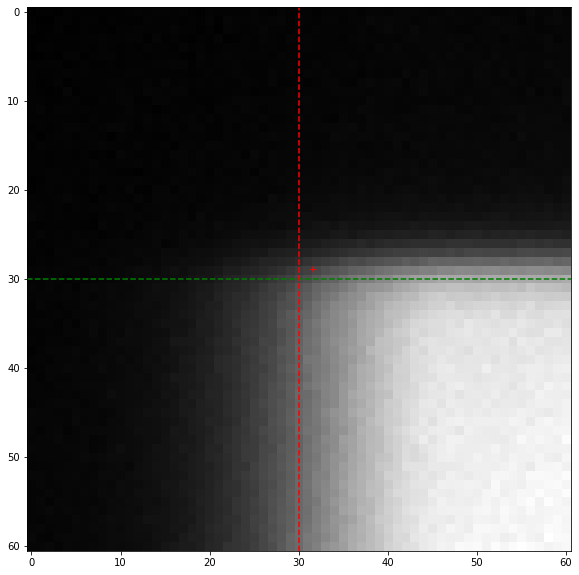

In [117]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(top_left_corner, 'gray')

ax.axhline(r, color='g', linestyle='dashed')
ax.axvline(r, color='r', linestyle='dashed')

ax.plot(cnr_col, cnr_row, 'r+')

print(cnr_col, cnr_row)

so the fitting sigmoid function should work for getting more accurate position of the corner, let's get the fitting function part done first.

31.607106329770193 28.861747711776346


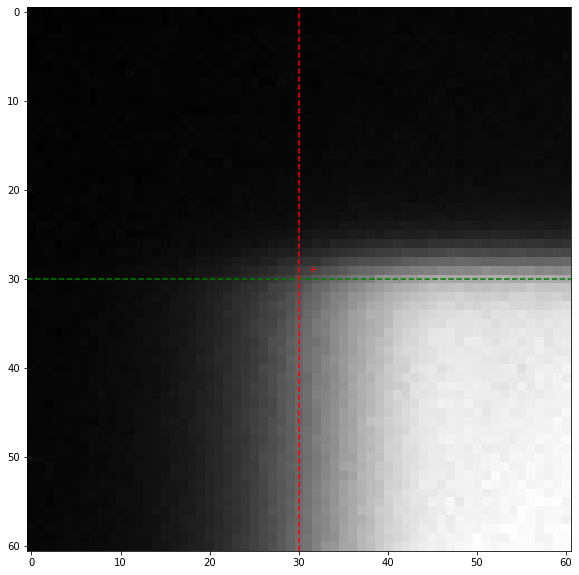

In [130]:
def sigmoid(x, xc=0, a=1):
    return 1.0/(1.0 + np.exp(-a*(x - xc)))

def fit_sigmoid(xdata, ydata):
    ydata -= ydata.min()
    ydata /= ydata.max()
    r = xdata.mean()
    
    return curve_fit(
        sigmoid, xdata, ydata,
        p0=[r, 1],
        bounds=([r-r*0.2, -np.inf],
                [r+r*0.2,  np.inf],
               ),
    )


# quick test (same image as above)
img = plt.imread('data/test_bigregion_3.tif')
edges = guess_slit_box(img)

r = 30
top_left_corner = img[edges['top' ]-r:edges['top' ]+r+1,
                      edges['left']-r:edges['left']+r+1]

horizontal_lp = np.average(top_left_corner, axis=0)
vertical_lp = np.average(top_left_corner, axis=1)

xdata = np.arange(r*2+1)

# fit the logistic curve
popt, pcov = fit_sigmoid(xdata, horizontal_lp)
cnr_col = popt[0]
popt, pcov = fit_sigmoid(xdata, vertical_lp)
cnr_row = popt[0]

# see the images
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(top_left_corner, 'gray')
ax.axhline(r, color='g', linestyle='dashed')
ax.axvline(r, color='r', linestyle='dashed')
ax.plot(cnr_col, cnr_row, 'r+')
print(cnr_col, cnr_row)

33.763807031111696 31.94926688252161


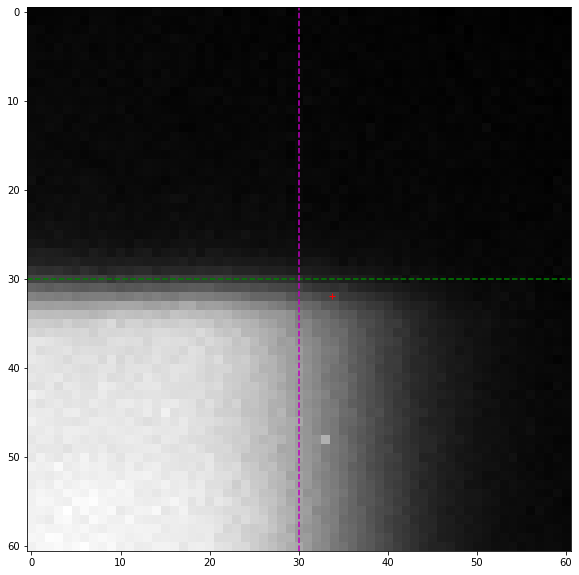

In [134]:
# testing top right corner
img = plt.imread('data/test_bigregion_0.tif')
edges = guess_slit_box(img)

r = 30
top_right_corner = img[edges['top' ]-r:edges['top' ]+r+1,
                      edges['right']-r:edges['right']+r+1]

horizontal_lp = np.average(top_right_corner, axis=0)
vertical_lp = np.average(top_right_corner, axis=1)

xdata = np.arange(r*2+1)

# fit the logistic curve
popt, pcov = fit_sigmoid(xdata, horizontal_lp)
cnr_col = popt[0]
popt, pcov = fit_sigmoid(xdata, vertical_lp)
cnr_row = popt[0]

# see the images
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(top_right_corner, 'gray')
ax.axhline(r, color='g', linestyle='dashed')
ax.axvline(r, color='m', linestyle='dashed')
ax.plot(cnr_col, cnr_row, 'r+')
print(cnr_col, cnr_row)

30.472924015080388 28.844587006431382


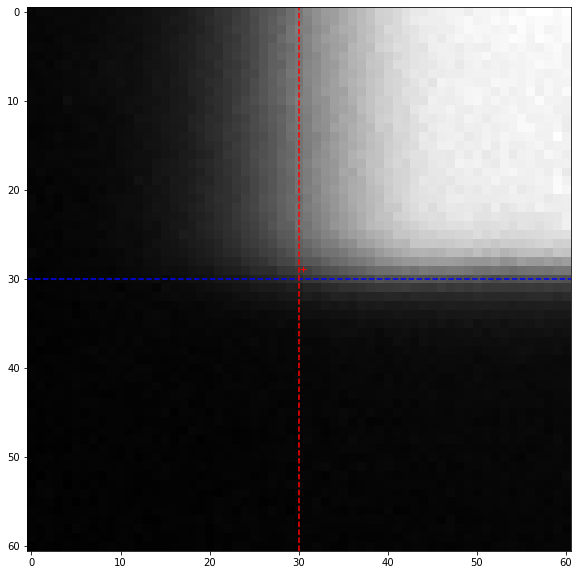

In [136]:
# testing bottom left corner
img = plt.imread('data/test_bigregion_0.tif')
edges = guess_slit_box(img)

r = 30
bot_left_corner = img[edges['bot' ]-r:edges['bot' ]+r+1,
                      edges['left']-r:edges['left']+r+1]

horizontal_lp = np.average(bot_left_corner, axis=0)
vertical_lp = np.average(bot_left_corner, axis=1)

xdata = np.arange(r*2+1)

# fit the logistic curve
popt, pcov = fit_sigmoid(xdata, horizontal_lp)
cnr_col = popt[0]
popt, pcov = fit_sigmoid(xdata, vertical_lp)
cnr_row = popt[0]

# see the images
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(bot_left_corner, 'gray')
ax.axhline(r, color='b', linestyle='dashed')
ax.axvline(r, color='r', linestyle='dashed')
ax.plot(cnr_col, cnr_row, 'r+')
print(cnr_col, cnr_row)

30.947981497558327 30.974521002069825


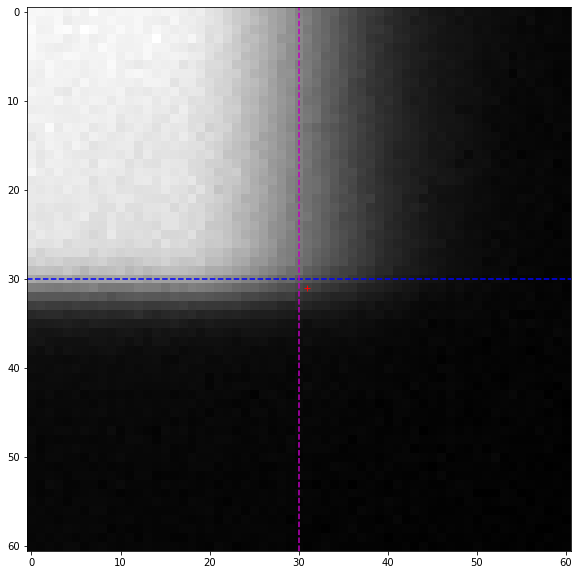

In [137]:
# testing bottom right corner
img = plt.imread('data/test_bigregion_0.tif')
edges = guess_slit_box(img)

r = 30
bot_right_corner = img[edges['bot' ]-r:edges['bot' ]+r+1,
                      edges['right']-r:edges['right']+r+1]

horizontal_lp = np.average(bot_right_corner, axis=0)
vertical_lp = np.average(bot_right_corner, axis=1)

xdata = np.arange(r*2+1)

# fit the logistic curve
popt, pcov = fit_sigmoid(xdata, horizontal_lp)
cnr_col = popt[0]
popt, pcov = fit_sigmoid(xdata, vertical_lp)
cnr_row = popt[0]

# see the images
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(bot_right_corner, 'gray')
ax.axhline(r, color='b', linestyle='dashed')
ax.axvline(r, color='m', linestyle='dashed')
ax.plot(cnr_col, cnr_row, 'r+')
print(cnr_col, cnr_row)

Now it is time to pack the necessary to a function

In [159]:
def detect_slit_corners(img, r=50):
    
    # guess the rough location first
    edges = guess_slit_box(img)
    le,re,te,be = edges['left'], edges['right'], edges['top'], edges['bot']
    
    r_row, r_col = min(r, be-te-1), min(r, re-le-1)
    
    safe_domain = lambda row, col: [(max(row - r_row, 0), min(row + r_row + 1, img.shape[0])), 
                                    (max(col - r_col, 0), min(col + r_col + 1, img.shape[1])),
                                   ]
    
    cnrs = [(te, le), (be, le), (be, re), (te, re)]
    
    for i, cnr in enumerate(cnrs):
        
        rowrange, colrange = safe_domain(*cnr)
        domain = img[rowrange[0]:rowrange[1], colrange[0]:colrange[1]]
        
        horizontal_lp = np.average(domain, axis=0)
        vertical_lp   = np.average(domain, axis=1)
        
        popt, pcov = fit_sigmoid(np.arange(len(vertical_lp)), vertical_lp)
        _row = popt[0]
        popt, pcov = fit_sigmoid(np.arange(len(horizontal_lp)), horizontal_lp)
        _col = popt[0]
        
        cnrs[i] = (rowrange[0]+_row, colrange[0]+_col)
    
    return cnrs

# quick check
for i in range(4):
    img = plt.imread(f'data/test_bigregion_{i}.tif')
    print(guess_slit_box(img))
    cnrs = detect_slit_corners(img)
    print(cnrs)

{'left': 114, 'right': 1884, 'top': 170, 'bot': 1031}
[(168.91378145401677, 116.02965053351498), (1029.831806772998, 114.68559228466557), (1031.448832280743, 1883.9576572250141), (172.16615812462797, 1885.0)]
{'left': 114, 'right': 1884, 'top': 170, 'bot': 1031}
[(168.88909788973677, 115.92281193820207), (1029.7967455007656, 114.76409285632784), (1031.366434597446, 1884.0370763005005), (172.07923262807833, 1885.0)]
{'left': 114, 'right': 1884, 'top': 170, 'bot': 1031}
[(168.80446014357906, 115.73256302453747), (1029.7020461523682, 114.80684967371761), (1031.33442086839, 1883.7559341960005), (171.94053903651948, 1885.0)]
{'left': 114, 'right': 1884, 'top': 170, 'bot': 1031}
[(168.91468446807434, 116.0322505502663), (1029.7710195401467, 114.67132255968976), (1031.3780975214702, 1883.9402770420402), (172.08071907496134, 1885.0)]


In [160]:
def printedges(edges):
    print(f"""
  {edges['top']} 
{edges['left']} {edges['right']}
  {edges['bot']}""")

def printcrns(cnrs):
    print(f"""
{cnrs[0]} ----- {cnrs[3]}
{cnrs[1]} ----- {cnrs[2]}""")

for i in range(4):
    img = plt.imread(f'data/test_bigregion_{i}.tif')
    printedges(guess_slit_box(img))
    cnrs = detect_slit_corners(img)
    printcrns(cnrs)


  170 
114 1884
  1031

(168.91378145401677, 116.02965053351498) ----- (172.16615812462797, 1885.0)
(1029.831806772998, 114.68559228466557) ----- (1031.448832280743, 1883.9576572250141)

  170 
114 1884
  1031

(168.88909788973677, 115.92281193820207) ----- (172.07923262807833, 1885.0)
(1029.7967455007656, 114.76409285632784) ----- (1031.366434597446, 1884.0370763005005)

  170 
114 1884
  1031

(168.80446014357906, 115.73256302453747) ----- (171.94053903651948, 1885.0)
(1029.7020461523682, 114.80684967371761) ----- (1031.33442086839, 1883.7559341960005)

  170 
114 1884
  1031

(168.91468446807434, 116.0322505502663) ----- (172.08071907496134, 1885.0)
(1029.7710195401467, 114.67132255968976) ----- (1031.3780975214702, 1883.9402770420402)


## systematic check

In [161]:
# big region (common cases)
for i in range(4):
    img = plt.imread(f'data/test_bigregion_{i}.tif')
    printedges(guess_slit_box(img))
    cnrs = detect_slit_corners(img)
    printcrns(cnrs)


  170 
114 1884
  1031

(168.91378145401677, 116.02965053351498) ----- (172.16615812462797, 1885.0)
(1029.831806772998, 114.68559228466557) ----- (1031.448832280743, 1883.9576572250141)

  170 
114 1884
  1031

(168.88909788973677, 115.92281193820207) ----- (172.07923262807833, 1885.0)
(1029.7967455007656, 114.76409285632784) ----- (1031.366434597446, 1884.0370763005005)

  170 
114 1884
  1031

(168.80446014357906, 115.73256302453747) ----- (171.94053903651948, 1885.0)
(1029.7020461523682, 114.80684967371761) ----- (1031.33442086839, 1883.7559341960005)

  170 
114 1884
  1031

(168.91468446807434, 116.0322505502663) ----- (172.08071907496134, 1885.0)
(1029.7710195401467, 114.67132255968976) ----- (1031.3780975214702, 1883.9402770420402)


In [162]:
# middle region (common cases)
for i in range(4):
    img = plt.imread(f'data/test_midregion_{i}.tif')
    printedges(guess_slit_box(img))
    cnrs = detect_slit_corners(img)
    printcrns(cnrs)


  352 
468 1340
  1071

(354.38533893293203, 468.4282881338561) ----- (350.176624281016, 1339.4113787439273)
(1070.575055653545, 469.09584354377716) ----- (1066.3620513065011, 1340.4166866357189)

  350 
461 1335
  1069

(352.5694097410833, 461.94031382896117) ----- (348.3621219552187, 1333.099645023987)
(1068.859595995629, 462.6648141933275) ----- (1064.6874454369595, 1334.0925760450673)

  349 
456 1330
  1068

(351.66000986150334, 457.24552112467825) ----- (347.4835907705821, 1328.413135716564)
(1067.8318918540397, 457.93847724779715) ----- (1063.640283201428, 1329.4255491183026)

  349 
457 1330
  1068

(351.6606183007293, 457.34227837439556) ----- (347.4925133406366, 1328.481693945028)
(1067.925517884443, 458.09110233440555) ----- (1063.6860772395742, 1329.5078450943583)


In [165]:
# small region (rare cases)
for i in range(4):
    img = plt.imread(f'data/test_smallregion_{i}.tif')
    printedges(guess_slit_box(img))
    cnrs = detect_slit_corners(img, r=30)
    printcrns(cnrs)


  655 
463 1339
  746

(652.7114732862601, 464.5370930629651) ----- (661.0, 1337.678997150899)
(741.7570756580309, 464.2343859801144) ----- (746.1733474652013, 1337.3125865127756)

  435 
1048 1148
  927

(441.0, 1054.0) ----- (441.0, 1143.5340998154124)
(921.0, 1053.0942155764699) ----- (921.0, 1142.0)

  723 
463 1339
  812

(723.9924872981613, 464.3833382868091) ----- (725.0602935172114, 1337.5252731930182)
(810.2061729437564, 464.2794382967203) ----- (810.4621511746516, 1337.324161509614)

  427 
853 950
  935

(433.0, 859.0) ----- (433.0, 945.7692120618364)
(929.0, 858.6683291530745) ----- (929.0, 944.0)


it seems like the small region are more sensitive to the radius settings, let's take a look at the images...

(950, 420)

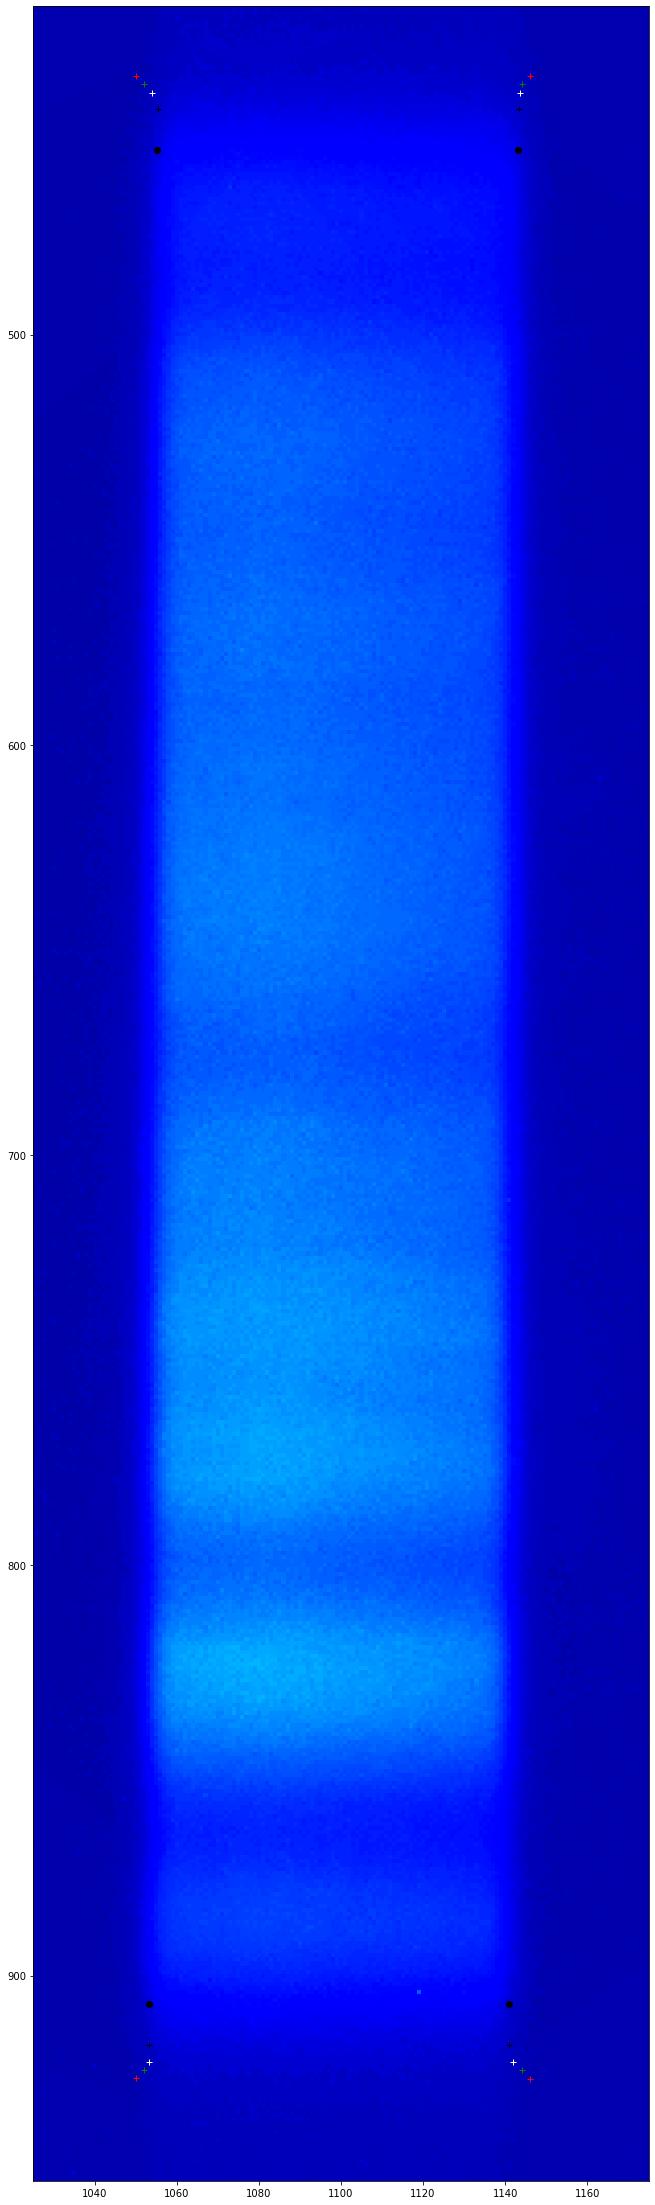

In [181]:
img = plt.imread(f'data/test_smallregion_1.tif')

fig, ax = plt.subplots(1,1,figsize=(15, 40))

ax.imshow(exposure.equalize_adapthist(img), 'jet')

cnrs = np.array(detect_slit_corners(img, r=10))
ax.plot(cnrs[:,1], cnrs[:,0], 'r+')

cnrs = np.array(detect_slit_corners(img, r=20))
ax.plot(cnrs[:,1], cnrs[:,0], 'g+')

cnrs = np.array(detect_slit_corners(img, r=30))
ax.plot(cnrs[:,1], cnrs[:,0], 'w+')

cnrs = np.array(detect_slit_corners(img))  # r=50, default value
ax.plot(cnrs[:,1], cnrs[:,0], 'k+')  

cnrs = np.array(detect_slit_corners(img, r=100))  # r=50, default value
ax.plot(cnrs[:,1], cnrs[:,0], 'ko')  

ax.set_xlim([1025, 1175])
ax.set_ylim([950, 420])

The size of the domain does matter as expected, and it seems to me that 50 pixels provide a good balance here.

> NOTE: If the domain is too large, the location of the corner might be affected by the tilt/curature of the blade; if the domain size is too small, we are risking no getting enough pixels to form the logstic curve.